<a href="https://colab.research.google.com/github/Timmy00125/Plate_detection_model/blob/main/cnn_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow keras opencv-python-headless pandas matplotlib kaggle


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
import tensorflow as tf
from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array



In [3]:
!pip install kaggle


In [4]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"timmypixel","key":"c66b08ead6c1a5111a45c8ec4ccc7c20"}'}

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/car-plate-detection
!unzip car-plate-detection.zip


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/car-plate-detection
License(s): CC0-1.0
100% 203M/203M [00:12<00:00, 22.1MB/s]
100% 203M/203M [00:12<00:00, 17.3MB/s]
Archive:  car-plate-detection.zip
  inflating: annotations/Cars0.xml   
  inflating: annotations/Cars1.xml   
  inflating: annotations/Cars10.xml  
  inflating: annotations/Cars100.xml  
  inflating: annotations/Cars101.xml  
  inflating: annotations/Cars102.xml  
  inflating: annotations/Cars103.xml  
  inflating: annotations/Cars104.xml  
  inflating: annotations/Cars105.xml  
  inflating: annotations/Cars106.xml  
  inflating: annotations/Cars107.xml  
  inflating: annotations/Cars108.xml  
  inflating: annotations/Cars109.xml  
  inflating: annotations/Cars11.xml  
  inflating: annotations/Cars110.xml  
  inflating: annotations/Cars111.xml  
  inflating: annotations/Cars112.xml  
  inflating: annotations/Cars113.xml  
  inflating: annotations/Cars114.xml  
  inflating: annotations/Cars115.xml  
  inflating: anno

In [46]:

def preprocess_annotations(annotations_path):
    path = glob(annotations_path + '/*.xml')
    labels_dict = dict(filepath=[], img=[], xmin=[], xmax=[], ymin=[], ymax=[])

    for filename in path:
        info = xet.parse(filename)
        root = info.getroot()
        member_img_name = root.find('filename').text
        member_object = root.find('object')
        labels_info = member_object.find('bndbox')
        xmin = int(labels_info.find('xmin').text)
        xmax = int(labels_info.find('xmax').text)
        ymin = int(labels_info.find('ymin').text)
        ymax = int(labels_info.find('ymax').text)

        labels_dict['filepath'].append(filename)
        labels_dict['img'].append(member_img_name)
        labels_dict['xmin'].append(xmin)
        labels_dict['xmax'].append(xmax)
        labels_dict['ymin'].append(ymin)
        labels_dict['ymax'].append(ymax)

    df = pd.DataFrame(labels_dict)
    df = df.sort_values(by=['filepath'])
    df = df.reset_index(drop=True)
    return df

# Usage
annotations_path = '/content/car-plate-detection/annotations'
df = preprocess_annotations(annotations_path)
df.to_csv('labels.csv', index=False)
print(df.head())

                                            filepath          img  xmin  xmax  \
0  /content/car-plate-detection/annotations/Cars0...    Cars0.png   226   419   
1  /content/car-plate-detection/annotations/Cars1...    Cars1.png   134   262   
2  /content/car-plate-detection/annotations/Cars1...   Cars10.png   140   303   
3  /content/car-plate-detection/annotations/Cars1...  Cars100.png   175   214   
4  /content/car-plate-detection/annotations/Cars1...  Cars101.png   167   240   

   ymin  ymax  
0   125   173  
1   128   160  
2     5   148  
3   114   131  
4   202   220  


In [47]:
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('/content/car-plate-detection/images', filename_image)
    return filepath_image

# Assuming 'df' is your DataFrame with annotation information
df['image_filepath'] = df['filepath'].apply(getFilename)

print(df.head())

                                            filepath          img  xmin  xmax  \
0  /content/car-plate-detection/annotations/Cars0...    Cars0.png   226   419   
1  /content/car-plate-detection/annotations/Cars1...    Cars1.png   134   262   
2  /content/car-plate-detection/annotations/Cars1...   Cars10.png   140   303   
3  /content/car-plate-detection/annotations/Cars1...  Cars100.png   175   214   
4  /content/car-plate-detection/annotations/Cars1...  Cars101.png   167   240   

   ymin  ymax                                   image_filepath  
0   125   173    /content/car-plate-detection/images/Cars0.png  
1   128   160    /content/car-plate-detection/images/Cars1.png  
2     5   148   /content/car-plate-detection/images/Cars10.png  
3   114   131  /content/car-plate-detection/images/Cars100.png  
4   202   220  /content/car-plate-detection/images/Cars101.png  


In [48]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:1000]#

['/content/car-plate-detection/images/Cars0.png',
 '/content/car-plate-detection/images/Cars1.png',
 '/content/car-plate-detection/images/Cars10.png',
 '/content/car-plate-detection/images/Cars100.png',
 '/content/car-plate-detection/images/Cars101.png',
 '/content/car-plate-detection/images/Cars102.png',
 '/content/car-plate-detection/images/Cars103.png',
 '/content/car-plate-detection/images/Cars104.png',
 '/content/car-plate-detection/images/Cars105.png',
 '/content/car-plate-detection/images/Cars106.png',
 '/content/car-plate-detection/images/Cars107.png',
 '/content/car-plate-detection/images/Cars108.png',
 '/content/car-plate-detection/images/Cars109.png',
 '/content/car-plate-detection/images/Cars11.png',
 '/content/car-plate-detection/images/Cars110.png',
 '/content/car-plate-detection/images/Cars111.png',
 '/content/car-plate-detection/images/Cars112.png',
 '/content/car-plate-detection/images/Cars113.png',
 '/content/car-plate-detection/images/Cars114.png',
 '/content/car-pla

In [49]:
image_path[87]

'/content/car-plate-detection/images/Cars177.png'

In [50]:
df[df['img'] == 'Cars177.png']

,filepath,img,xmin,xmax,ymin,ymax,image_filepath
87,/content/car-plate-detection/annotations/Cars1...,Cars177.png,149,272,166,193,/content/car-plate-detection/images/Cars177.png


In [51]:
def visualize_image_with_bbox(file_path, bbox, title="Image with bounding box"):
    img = io.imread(file_path)
    fig = px.imshow(img)
    fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),
                      xaxis_title=title)
    fig.add_shape(type='rect',
                  x0=bbox[0], y0=bbox[1], x1=bbox[2], y1=bbox[3],
                  xref='x', yref='y',
                  line_color='cyan')
    return fig

# Usage example:
file_path = image_path[87]
bbox = [149, 166, 272, 193]  # [x0, y0, x1, y1]
fig = visualize_image_with_bbox(file_path, bbox, "Figure 8 - N2.jpeg with bounding box")
fig.show()

In [54]:
import numpy as np
from sklearn.model_selection import train_test_split

def load_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224)) # Resize to fit model input
    return image / 255.0 # Normalize to [0, 1] range

# Load images and labels
images = []
labels = []
for index, row in df.iterrows():
    image_path = row['image_filepath']
    images.append(load_image(image_path))
    labels.append([row['xmin'], row['ymin'], row['xmax'], row['ymax']]) # Bounding box coordinates

images = np.array(images)
labels = np.array(labels)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)


In [55]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(4) # Output layer for bounding box coordinates
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [60]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")

# Save the model
model.save('car_plate_detection_model.h5')


3/3 [==============================] - 0s 23ms/step - loss: 3352.4304 - accuracy: 0.8506
Validation Loss: 3352.430419921875
Validation Accuracy: 0.8505747318267822


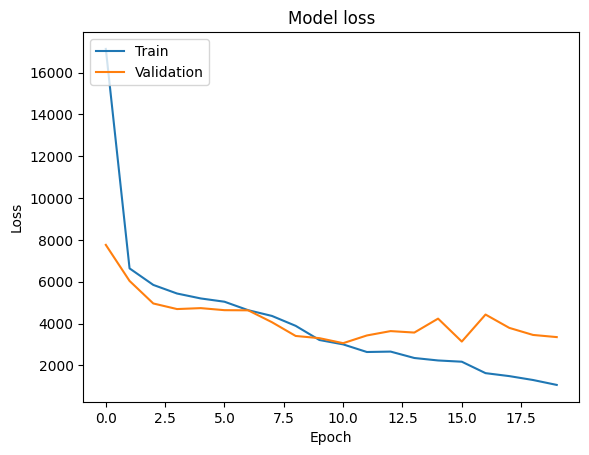

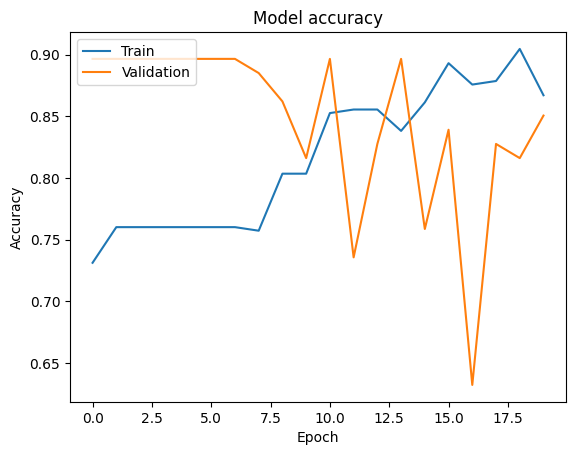

In [58]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
